In [1]:
# === colab configuration ===
# p.s. when training on colab, weights are saved on Drive (directory DSCAS/weights).
# p.p.s. skip this cell if running demo file locally!

! pip install torch-summary
! pip install ray
from google.colab import drive
import sys

# setting paths
repository_path = '/content/deep-seasonal-color-analysis-system/'
dataset_path = repository_path + 'headsegmentation_dataset_ccncsa/'
dataset_path_drive = '/content/drive/MyDrive/DSCAS/headsegmentation_dataset_ccncsa/'
weights_path = repository_path + 'models/weights/'
weights_path_drive = '/content/drive/MyDrive/DSCAS/weights/'
sys.path.insert(0, repository_path)

# cloning project repository and downloading dataset
drive.mount('/content/drive')
! test ! -d $repository_path && git clone https://github.com/mrcmich/deep-seasonal-color-analysis-system.git
! test ! -d $dataset_path && cp -R $dataset_path_drive $dataset_path
%cd $repository_path

# setting branch and pulling updates
branch = 'fastscnn_hyperparameters_tuning__refactoring'
! git checkout $branch
! git pull origin $branch

executing_on_colab = True

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive
Cloning into 'deep-seasonal-color-analysis-system'...
remote: Enumerating objects: 503, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 503 (delta 106), reused 141 (delta 93), pack-reused 312
Receiving objects: 100% (503/503), 81.82 MiB | 17.30 MiB/s, done.
Resolving deltas: 100% (252/252), done.
/content/deep-seasonal-color-analysis-system
Already on 'main'
Your branch is up to date with 'origin/main'.
From https://github.com/mrcmich/deep-seasonal-color-analysis-system
 * branch            main       -> FETCH_HEAD
Already up to date.


In [2]:
import torch
from torch import nn
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from models import dataset, training_and_testing
from models.local.LEDNet.models import lednet
from metrics_and_losses import metrics
from utils import segmentation_labels, utils
import matplotlib.pyplot as plt
from palette_classification import color_processing
import torchsummary
from models import config

try:
  executing_on_colab
except NameError:
  executing_on_colab = False
  weights_path = config.WEIGHTS_PATH
  dataset_path = config.DATASET_PATH

In [4]:
# defining transforms
tH, tW = 256, 256
image_transform = T.Compose([T.Resize((tH, tW)), T.Normalize(config.NORMALIZE_MEAN, config.NORMALIZE_STD)])
target_transform = T.Compose([T.Resize((tH, tW))])

# fetching dataset
n_classes = len(segmentation_labels.labels)
img_paths, label_paths = dataset.get_paths(dataset_path, file_name=config.DATASET_INDEX_NAME)
X_train, X_test, Y_train, Y_test = train_test_split(
    img_paths, label_paths, test_size=0.20, random_state=99, shuffle=True)
train_dataset = dataset.MyDataset(X_train, Y_train, image_transform, target_transform)
test_dataset = dataset.MyDataset(X_test, Y_test, image_transform, target_transform)

# training and test hyperparameters
batch_size = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# training hyperparameters
n_epochs = 50

# model, loss, score function
model_name = 'lednet_ccncsa'
model = lednet.LEDNet(num_classes=n_classes, output_size=(tH, tW))
loss_fn = nn.CrossEntropyLoss()
score_fn = metrics.batch_mIoU

# optimizer
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# printing model summary
model_summary = torchsummary.summary(model, input_data=(batch_size, 3, tH, tW), batch_dim=None, verbose=0)
print(model_summary)

Layer (type:depth-idx)                        Output Shape              Param #
├─Encoder: 1-1                                [32, 128, 32, 32]         --
|    └─DownsamplerBlock: 2-1                  [32, 32, 128, 128]        --
|    |    └─MaxPool2d: 3-1                    [32, 3, 128, 128]         --
|    |    └─Conv2d: 3-2                       [32, 29, 128, 128]        812
|    |    └─BatchNorm2d: 3-3                  [32, 32, 128, 128]        64
|    |    └─ReLU: 3-4                         [32, 32, 128, 128]        --
|    └─ModuleList: 2                          []                        --
|    |    └─SS_nbt_module: 3-5                [32, 32, 128, 128]        6,400
|    |    └─SS_nbt_module: 3-6                [32, 32, 128, 128]        6,400
|    |    └─SS_nbt_module: 3-7                [32, 32, 128, 128]        6,400
|    |    └─DownsamplerBlock: 3-8             [32, 64, 64, 64]          9,376
|    |    └─SS_nbt_module: 3-9                [32, 64, 64, 64]          25,088
|  

In [6]:
# training
results = training_and_testing.train_model(
    device, model, train_dataset, batch_size, n_epochs, score_fn, loss_fn, optimizer, 
    lr_scheduler=None, evaluate=True, verbose=True)

Device: cuda.
--- Epoch 1/50 ---
average_train_loss: 0.7845346262821784, average_train_score: 0.3603883683681488
average_val_loss: 0.5995443028116983, average_val_score: 0.3803545832633972
--- Epoch 2/50 ---
average_train_loss: 0.5036462625207385, average_train_score: 0.3945969343185425
average_val_loss: 0.47815206836140345, average_val_score: 0.3799911439418793
--- Epoch 3/50 ---
average_train_loss: 0.4079394970524345, average_train_score: 0.4200781583786011
average_val_loss: 0.3379221489978215, average_val_score: 0.447230726480484
--- Epoch 4/50 ---
average_train_loss: 0.33517947296301526, average_train_score: 0.4566168785095215
average_val_loss: 0.3057719433591479, average_val_score: 0.47510090470314026
--- Epoch 5/50 ---
average_train_loss: 0.2877538091266936, average_train_score: 0.4840760827064514
average_val_loss: 0.2831553237305747, average_val_score: 0.49904435873031616
--- Epoch 6/50 ---
average_train_loss: 0.24948505581783773, average_train_score: 0.506478488445282
average_v

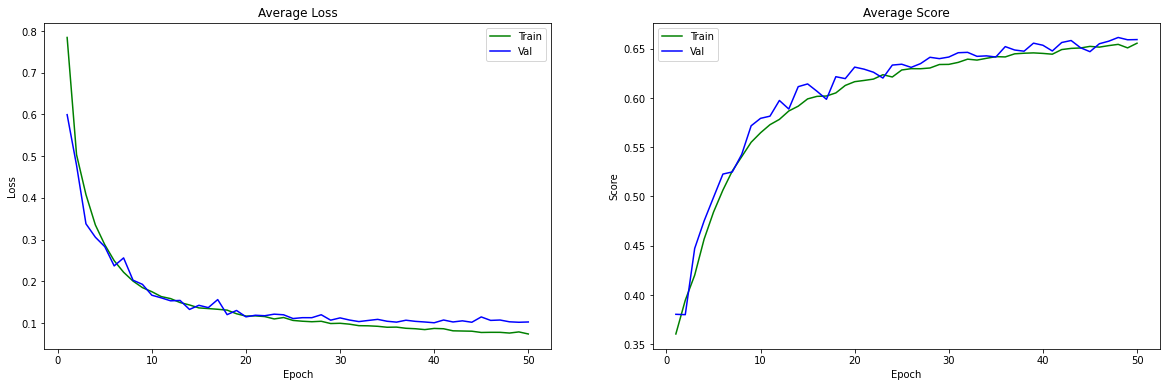

In [7]:
# plotting training result
training_and_testing.plot_training_results(results, plotsize=(20, 6))

In [ ]:
# resetting model, optimizer, learning rate scheduler
final_model = lednet.LEDNet(num_classes=n_classes)
final_optimizer = torch.optim.Adam(final_model.parameters(), lr=learning_rate)

# re-training model on entire training set and saving its weights
final_n_epochs = n_epochs // 2
training_and_testing.train_model(
    device, final_model, train_dataset, batch_size, final_n_epochs, score_fn, loss_fn, final_optimizer, verbose=True)

# saving final model's weights
torch.save(final_model.state_dict(), weights_path + model_name + '.pth')
if executing_on_colab is True:
  torch.save(final_model.state_dict(), weights_path_drive + model_name + '.pth')

Device: cuda.
--- Epoch 1/25 ---
average_train_loss: 0.7523714005225507, average_train_score: 0.3637666404247284
--- Epoch 2/25 ---
average_train_loss: 0.43553848034244474, average_train_score: 0.4161882996559143
--- Epoch 3/25 ---
average_train_loss: 0.33654597246473694, average_train_score: 0.45946621894836426
--- Epoch 4/25 ---
average_train_loss: 0.2702512041131174, average_train_score: 0.5007180571556091
--- Epoch 5/25 ---
average_train_loss: 0.2300378768986709, average_train_score: 0.5287885069847107
--- Epoch 6/25 ---
average_train_loss: 0.20158936285366447, average_train_score: 0.5523017644882202
--- Epoch 7/25 ---
average_train_loss: 0.18254394874373592, average_train_score: 0.5693351626396179
--- Epoch 8/25 ---
average_train_loss: 0.16674250831543388, average_train_score: 0.5854078531265259
--- Epoch 9/25 ---
average_train_loss: 0.15476833157620187, average_train_score: 0.5969145894050598
--- Epoch 10/25 ---
average_train_loss: 0.14741664794758502, average_train_score: 0.6064

In [ ]:
# loading pretrained final model
try:
    final_model
except:
    final_model = lednet.LEDNet(num_classes=n_classes)
    final_model.load_state_dict(torch.load(weights_path + model_name + '.pth'))

# testing model on test dataset
test_score_fn = metrics.batch_IoU
label_names = list(segmentation_labels.labels.keys())
batch_IoU = training_and_testing.test_model(device, final_model, test_dataset, batch_size, test_score_fn)
batch_IoU_with_labels = { label: score for label, score in list(zip(label_names, batch_IoU.tolist())) }
batch_mIoU = batch_IoU.mean().item()
for label in batch_IoU_with_labels:
    print(f'batch_IoU_{label}: {batch_IoU_with_labels[label]}')
print(f'batch_mIoU={batch_mIoU}')

Device: cuda.

Inference completed in around 55 seconds.
batch_IoU_background: 0.9571017622947693
batch_IoU_lips: 0.5220475196838379
batch_IoU_eyes: 0.2848397195339203
batch_IoU_nose: 0.7007464170455933
batch_IoU_skin: 0.85901939868927
batch_IoU_hair: 0.8032673597335815
batch_IoU_eyebrows: 0.35896483063697815
batch_IoU_ears: 0.6642786264419556
batch_IoU_teeth: 0.6037340760231018
batch_IoU_beard: 0.8501461744308472
batch_IoU_sunglasses: 0.9131664633750916
batch_mIoU=0.6833920478820801


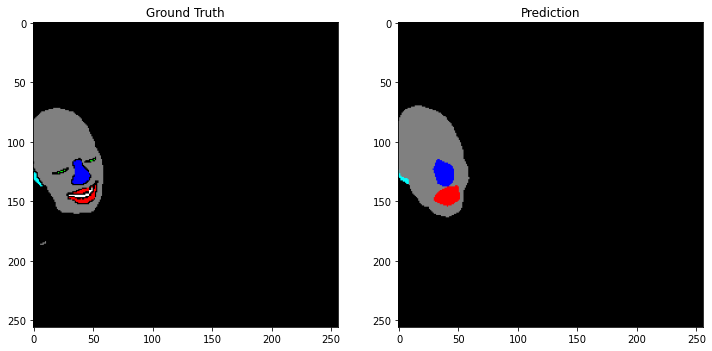

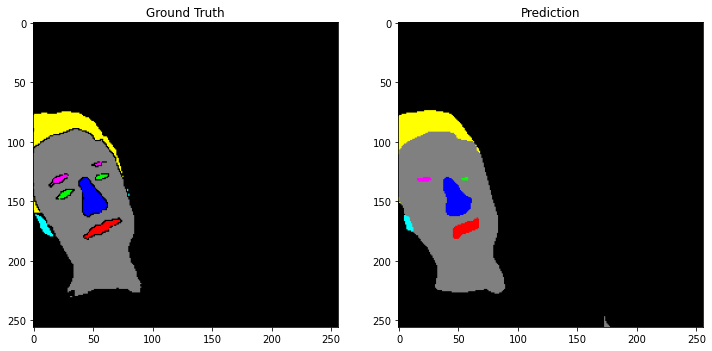

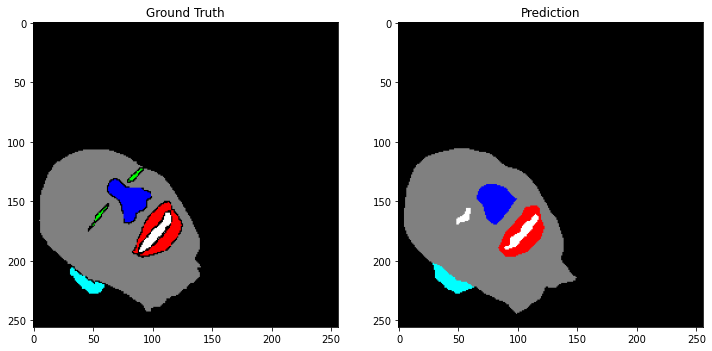

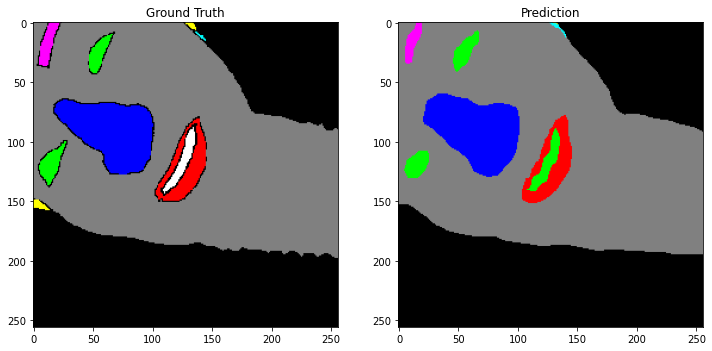

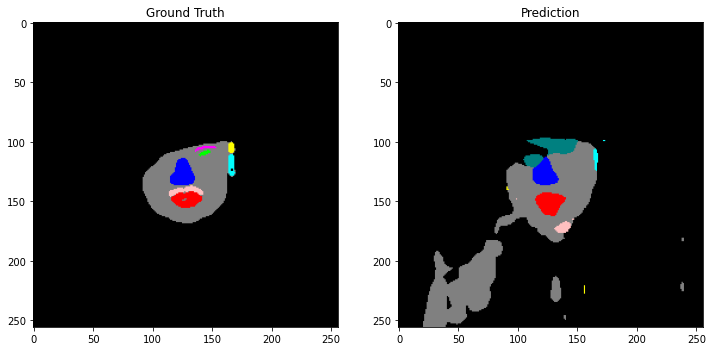

In [ ]:
# plotting some examples from test dataset
utils.plot_random_examples(device, final_model, test_dataset, n_examples=5)